In [1]:
import collections

import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
import tensorflow_federated as tff
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split


from keras.models import Sequential 
from keras.initializers import HeNormal, GlorotNormal
from keras.layers import Dense
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


TEST_SIZE = 0.2
NUM_CLIENTS = 10
BATCH_SIZE = 512
DROPOUT = 0.2
EPOCHS = 10
PREFETCH_BUFFER = 10
NUM_ROUNDS = 5
UNBALANCED = False
path = os.path.dirname(tff.__file__)
print(path)

np.random.seed(42)
tf.get_logger().setLevel('ERROR')

/home/ella/Documents/FL/venv-federated/lib/python3.9/site-packages/tensorflow_federated


In [2]:
# Import del dataset e divisione in train e test
train_df = pd.read_csv('datasets/train_internet.csv')
test_df = pd.read_csv('datasets/test_internet.csv')

train_x = train_df.drop(columns=['label'])
train_y = train_df['label'].astype(int)

test_x = test_df.drop(columns=['label'])
test_y = test_df['label'].astype(int)

# Funzione per il preprocessing dei dati del singolo client che divide il dataset in batch
def preprocess(dataset):
  return dataset.repeat(EPOCHS).batch(BATCH_SIZE).prefetch(PREFETCH_BUFFER)

# funzione per aggiungere una colonna client_num al dataset in modo tale che ogni client abbia una percentuale di 
# righe del dataset diversa indipendente dalla label. La percentuale è generata a caso, ma la somma deve fare il 100% del dataset
def client_unbalanced(dataset, num_clients):
    client_num = []
    prob = np.random.pareto(1, num_clients)
    prob /= np.sum(prob)
    print(prob)
    for i in range(len(dataset)):
        client_num.append(np.random.choice(num_clients, p=prob))
    print(len(client_num))
    # stampa numero di volte che compare ogni client in client_num
    print([client_num.count(x) for x in range(num_clients)])
    dataset['client_num'] = client_num
    return dataset

# Funzione per la creazione di un dataset ClientData a partire dal dataset di training a cui viene
# aggiunta una colonna client_num che assegna ad ogni riga un client randomico
def create_clients(dataset, unbalanced, num_clients=NUM_CLIENTS):
    if unbalanced: 
        dataset = client_unbalanced(dataset, num_clients)
    else:
        # Viene creata una lista randomica di client
        clients = np.random.uniform(0, 1, len(dataset))
        dataset['client_num'] = clients

    # Viene convertito il dataset in dizionari, uno per ogni client, con label e pixel associati
    client_train_dataset = collections.OrderedDict()
    grouped_dataset = dataset.groupby('client_num')
    for key, item in grouped_dataset:
        current_client = grouped_dataset.get_group(key)
        data = collections.OrderedDict((('y', train_y), ('x', train_x)))
        client_train_dataset[key] = data

    # I dizionari vengono convertiti in ClientDataset
    def serializable_dataset_fn(client_id):
        client_data = client_train_dataset[client_id]
        return tf.data.Dataset.from_tensor_slices(client_data)

    tff_train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
        client_ids=list(client_train_dataset.keys()),
        serializable_dataset_fn=serializable_dataset_fn
    )

    return tff_train_data

# Creazione della lista contenente i client con i relativi dataset
elem_spec = {}
def init(dataset, active_clients=NUM_CLIENTS, unbalanced=False): 
    client_data_df = create_clients(dataset, unbalanced, active_clients)
    client_ids = sorted(client_data_df.client_ids)[:active_clients]
    return [preprocess(client_data_df.create_tf_dataset_for_client(x)) for x in client_ids]

In [3]:
def create_keras_model():
  model = Sequential()

  model.add(Dense(112, activation='softmax', input_dim=train_x.shape[-1]))
  model.add(Dropout(DROPOUT))
  model.add(Dense(272, activation='tanh'))
  model.add(Dropout(DROPOUT))
  model.add(Dense(4, activation='softmax'))   

  return model

In [4]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=elem_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [5]:
def aggregator(algo, prox):
    if algo == 'weighted avg':
        training_process = tff.learning.algorithms.build_weighted_fed_avg(model_fn, 
                                                                          client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01),
                                                                          server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01))

    if algo == 'unweighted avg':
        training_process = tff.learning.algorithms.build_unweighted_fed_avg(model_fn, 
                                                                            client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01),
                                                                            server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01))

    if algo == 'weighted prox':
        training_process = tff.learning.algorithms.build_weighted_fed_prox(model_fn, 
                                                                           proximal_strength=prox, 
                                                                           client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01),
                                                                           server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01))
    if algo == 'unweighted prox':
        training_process = tff.learning.algorithms.build_weighted_fed_prox(model_fn, 
                                                                           proximal_strength=prox,
                                                                           client_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01),
                                                                           server_optimizer_fn=tff.learning.optimizers.build_adam(learning_rate=0.01))
    return training_process

In [ ]:
federated_train_data = init(train_df)
elem_spec = federated_train_data[0].element_spec
training_process = aggregator('weighted avg', 20.0)
train_state = training_process.initialize()
for round_num in range(NUM_ROUNDS):
  result = training_process.next(train_state, federated_train_data)
  train_state = result.state
  train_metrics = result.metrics
  print('round {:2d}, metrics={}'.format(round_num, train_metrics))

In [6]:
#evaluation
def keras_evaluate(state, training_process):
  # Take our global model weights and push them back into a Keras model to
  # use its standard `.evaluate()` method.
  keras_model = create_keras_model()
  keras_model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
  model_weights = training_process.get_model_weights(state)
  model_weights.assign_weights_to(keras_model)
  loss, accuracy = keras_model.evaluate(x=test_x, y=test_y)
  print('\tEval: loss={l:.3f}, accuracy={a:.3f}'.format(l=loss, a=accuracy))
  return loss, accuracy

In [ ]:
keras_evaluate(train_state, training_process)

Esperimenti
==============

***Algoritmo di aggregazione***\

In [14]:
federated_train_data = init(train_df)
elem_spec = federated_train_data[0].element_spec
# Tuning del parametro di proximal strength
def tune_proximal_strength():
    prox_list = []
    for i in [1.0, 10.0, 20.0, 128.0, 256.0, 512.0]:
        training_process = aggregator('weighted prox', i)
        train_state = training_process.initialize()
        curr = []
        for round_num in range(NUM_ROUNDS):
            result = training_process.next(train_state, federated_train_data)
            train_state = result.state
            train_metrics = result.metrics
            print('round {:2d}, metrics={}'.format(round_num, train_metrics))
            # creare una ltupla con round_num e il valore di accuracy
            acc_tuple = (round_num, 
                         train_metrics['client_work']['train']['sparse_categorical_accuracy'])
            curr.append(acc_tuple)
        # creare una tupla con il valore di proximal strength e la lista di tuple
        prox_list.append((i, curr))

    return prox_list

prox_list = tune_proximal_strength()

round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.55417275), ('loss', 1.5071614), ('num_examples', 218800), ('num_batches', 430)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.6282267), ('loss', 2.849792), ('num_examples', 218800), ('num_batches', 430)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.6828839), ('loss', 1.6388844), ('num_examples', 218800), ('num_batches', 430)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), (

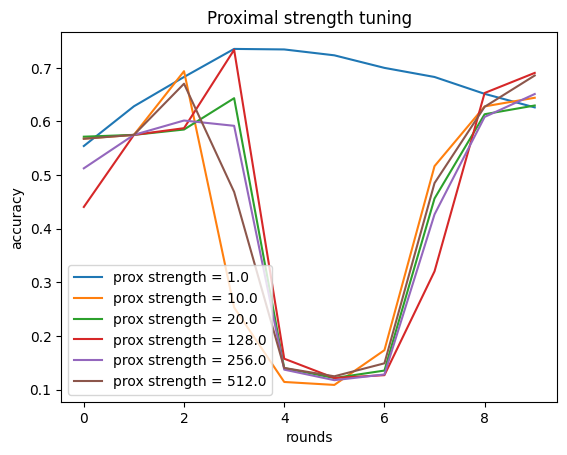

In [15]:
i = 0
rounds = []
accuracies = []

for algo, acc_list in prox_list:
    rounds.append([x[0] for x in acc_list])
    accuracies.append([x[1] for x in acc_list])
    i+=1

fig, ax = plt.subplots()
for i in range(len(prox_list)):
    ax.plot(rounds[i], accuracies[i], label='prox strength = {}'.format(prox_list[i][0]))
ax.set(xlabel='rounds', ylabel='accuracy',
       title='Proximal strength tuning')
ax.legend()
plt.show()


In [16]:
federated_train_data = init(train_df, unbalanced=True)
elem_spec = federated_train_data[0].element_spec

def agg_experiment():
    prox_list = []
    for i in ['weighted avg', 'unweighted avg', 'weighted prox', 'unweighted prox']:
        training_process = aggregator(i, 1.0)
        train_state = training_process.initialize()
        curr = []
        for round_num in range(NUM_ROUNDS):
            result = training_process.next(train_state, federated_train_data)
            train_state = result.state
            train_metrics = result.metrics
            print('round {:2d}, metrics={}'.format(round_num, train_metrics))
            # creare una tupla con round_num e il valore di accuracy
            acc_tuple = (round_num, 
                         train_metrics['client_work']['train']['sparse_categorical_accuracy'])
            curr.append(acc_tuple)
        # creare una tupla con il valore di proximal strength e la lista di tuple
        prox_list.append((i, curr))
    return prox_list

agg_algo_list = agg_experiment()


[0.13641323 0.07265235 0.01287927 0.35779289 0.0745594  0.04666748
 0.00456959 0.02959254 0.0312243  0.23364896]
2188
[312, 144, 30, 786, 171, 119, 15, 58, 67, 486]
round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8463254), ('loss', 0.3685731), ('num_examples', 218800), ('num_batches', 430)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8779799), ('loss', 0.30826312), ('num_examples', 218800), ('num_batches', 430)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accur

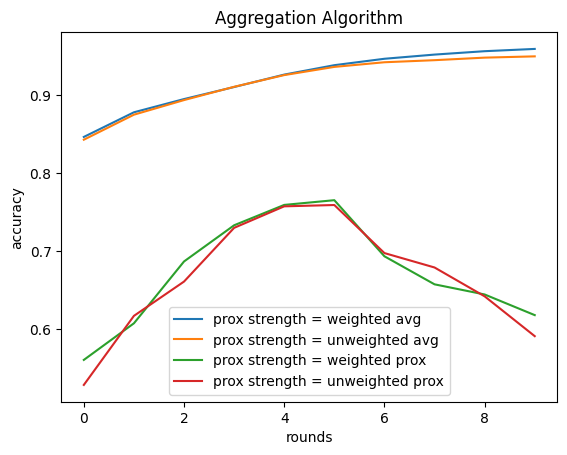

In [17]:
i = 0
rounds = []
accuracies = []

for algo, acc_list in agg_algo_list:
    rounds.append([x[0] for x in acc_list])
    accuracies.append([x[1] for x in acc_list])
    i+=1

fig, ax = plt.subplots()
for i in range(len(agg_algo_list)):
    ax.plot(rounds[i], accuracies[i], label='prox strength = {}'.format(agg_algo_list[i][0]))
ax.set(xlabel='rounds', ylabel='accuracy',
       title='Aggregation Algorithm')
ax.legend()
plt.show()

***Numero e Percentuale clients***

In [7]:
import math
def client_perc_experiment():
    client_list = []
    eval_list = []
    for i in [10, 50, 100]:
        perc_list = []
        for j in [0.25, 0.50, 0.75, 1]:
            federated_train_data = init(train_df, active_clients=math.floor(i*j))
            global elem_spec 
            elem_spec = federated_train_data[0].element_spec
            training_process = aggregator('weighted avg', 1.0)
            train_state = training_process.initialize()
  
            curr = []
            for round_num in range(NUM_ROUNDS):
                result = training_process.next(train_state, federated_train_data)
                train_state = result.state
                train_metrics = result.metrics
                print('round {:2d}, metrics={}'.format(round_num, train_metrics))
                # creare una tupla con round_num e il valore di accuracy
                acc_tuple = (round_num, 
                             train_metrics['client_work']['train']['sparse_categorical_accuracy'])
                curr.append(acc_tuple)
            eval = keras_evaluate(train_state, training_process)
            eval_list.append((i, j, eval))
            # lista con tupla di percentuale e lista di tuple di accuracy per round
            perc_list.append((j, curr))
        client_list.append((i, perc_list))
    return client_list, eval_list

client_list, eval_list = client_perc_experiment()

round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8463894), ('loss', 0.3677698), ('num_examples', 43760), ('num_batches', 86)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.8805987), ('loss', 0.30627328), ('num_examples', 43760), ('num_batches', 86)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
round  2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.89645797), ('loss', 0.26301733), ('num_examples', 43760), ('num_batches', 86)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('fi

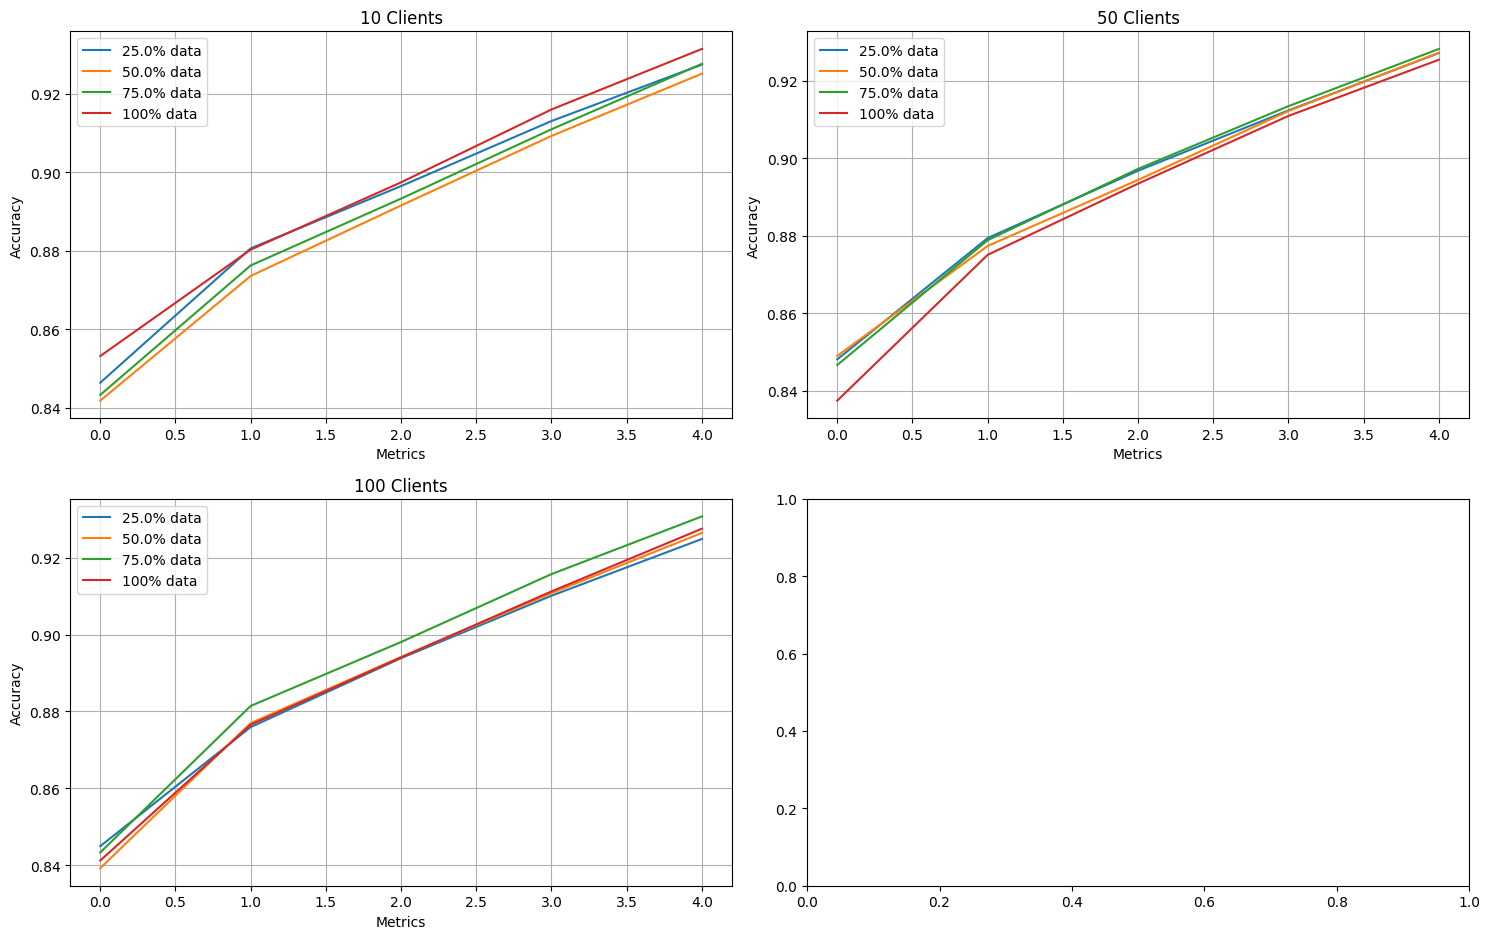

In [8]:
def plot_metric(data, metric_index, metric_name):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    
    for i, (clients, portions_data) in enumerate(data):
        ax = axs[i // 2, i % 2]
        for portion, epoch_data in portions_data:
            epochs = [e[0] for e in epoch_data]
            metric_values = [e[metric_index] for e in epoch_data]
            ax.plot(epochs, metric_values, label=f'{portion*100}% data')
        
        ax.set_title(f'{clients} Clients')
        ax.set_xlabel('Metrics')
        ax.set_ylabel(metric_name)
        ax.legend()
        ax.grid(True) 
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Plottiamo i grafici per ciascuna metrica
plot_metric(client_list, 1, 'Accuracy')  # Accuracy
